In [1]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\WilhelmB\Documents\DiagAssistAI


In [2]:
!python scripts/install_deps.py

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
!pip install -r requirements.txt

In [4]:
%pip install -e .  --verbose

Using pip 24.0 from c:\Users\WilhelmB\miniconda3\envs\prueba2\lib\site-packages\pip (python 3.10)
Obtaining file:///C:/Users/WilhelmB/Documents/DiagAssistAI
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for LangSam (pyproject.toml): started
  Building editable for LangSam (pyproject.toml): finished with status 'done'
  Created wheel for LangSam: filename=langsam-0.1.0-py3-none-any.whl size=5437 sha256=672eeae9442a0b007213c1a3fab1d4177c7fa0bb2ac9507eea7e15d05fae5d9c
  Stored in directory: C:\Users\WilhelmB\AppData\Local\Temp\

  Running command pip subprocess to install build dependencies
    Using cached poetry_core-1.9.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached poetry_core-1.9.0-py3-none-any.whl (309 kB)
  Running command Checking if build backend supports build_editable
  Running command Getting requirements to build editable
  Running command Preparing editable metadata (pyproject.toml)
  Running command Building editable for LangSam (pyproject.toml)


In [5]:
!python setup.py build_ext --inplace --verbose

Compiling with CUDA
running build_ext
copying build\lib.win-amd64-cpython-310\groundingdino\_C.cp310-win_amd64.pyd -> src\groundingdino


c:\Users\WilhelmB\miniconda3\envs\prueba2\lib\site-packages\torch\utils\cpp_extension.py:495: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))


In [6]:
from groundingdino import _C

c:\Users\WilhelmB\miniconda3\envs\prueba2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from LangSAM.SamLangDino import SamDino
from src.DataSets.Mamitas_Thermal_Dataset.Mamitas_Dataset import Mamitas_Thermal_Feet_Dataset, ToBoolTensor, PermuteTensor 
from torchvision.transforms import transforms
import torch

In [8]:
model = SamDino(SAM='vit_h')

final text_encoder_type: bert-base-uncased


In [9]:
transform_mask = transforms.Compose([
    ToBoolTensor(),
    PermuteTensor((1,2,0))
])
transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.uint8),
    PermuteTensor((1,2,0))
])

_, val_dataset = Mamitas_Thermal_Feet_Dataset().generate_dataset_with_val(torch_dataset=True,
                                                   batch_size=38,
                                                   shuffle=False,
                                                   split_val=0.2,
                                                   merge_image=True,
                                                   transform_mask=transform_mask,
                                                   transform_img=transform_img)

DATASET = Mamitas_Thermal_Feet_Dataset().generate_dataset(transform_img=transform_img,
                                                          transform_mask=transform_mask,
                                                          merge_image=True,
                                                          )

Error al cargar las credenciales o descargar el dataset: No module named 'kaggle'
Train_dataset: 150
Val_dataset: 38
Error al cargar las credenciales o descargar el dataset: No module named 'kaggle'


In [10]:
imgp,maskp,idp = DATASET.__getitem__(1)

In [11]:
text_prompt="feet,foot"
box_threshold=0.10
text_threshold=0.25
process_box_threshold = 0.10

In [12]:
boxes, logits, phrases = model.predict_dino(imgp,text_prompt,box_threshold,text_threshold)

In [13]:
import supervision as sv
from groundingdino.util.inference import annotate
def plot_image(image,boxes,logits,phrases):
  annotated_frame = annotate(image_source=image, boxes=boxes, logits=logits, phrases=phrases)
  sv.plot_image(annotated_frame, (16, 16))

In [14]:
import numpy as np

In [15]:
from LangSAM.utils import process_box_batch

In [16]:
nb, nl, nnp = process_box_batch(imgp.shape[:2],[boxes],[logits],[phrases],0.1)

In [17]:
nb

tensor([[0.5285, 0.4768, 0.7561, 0.8836]])

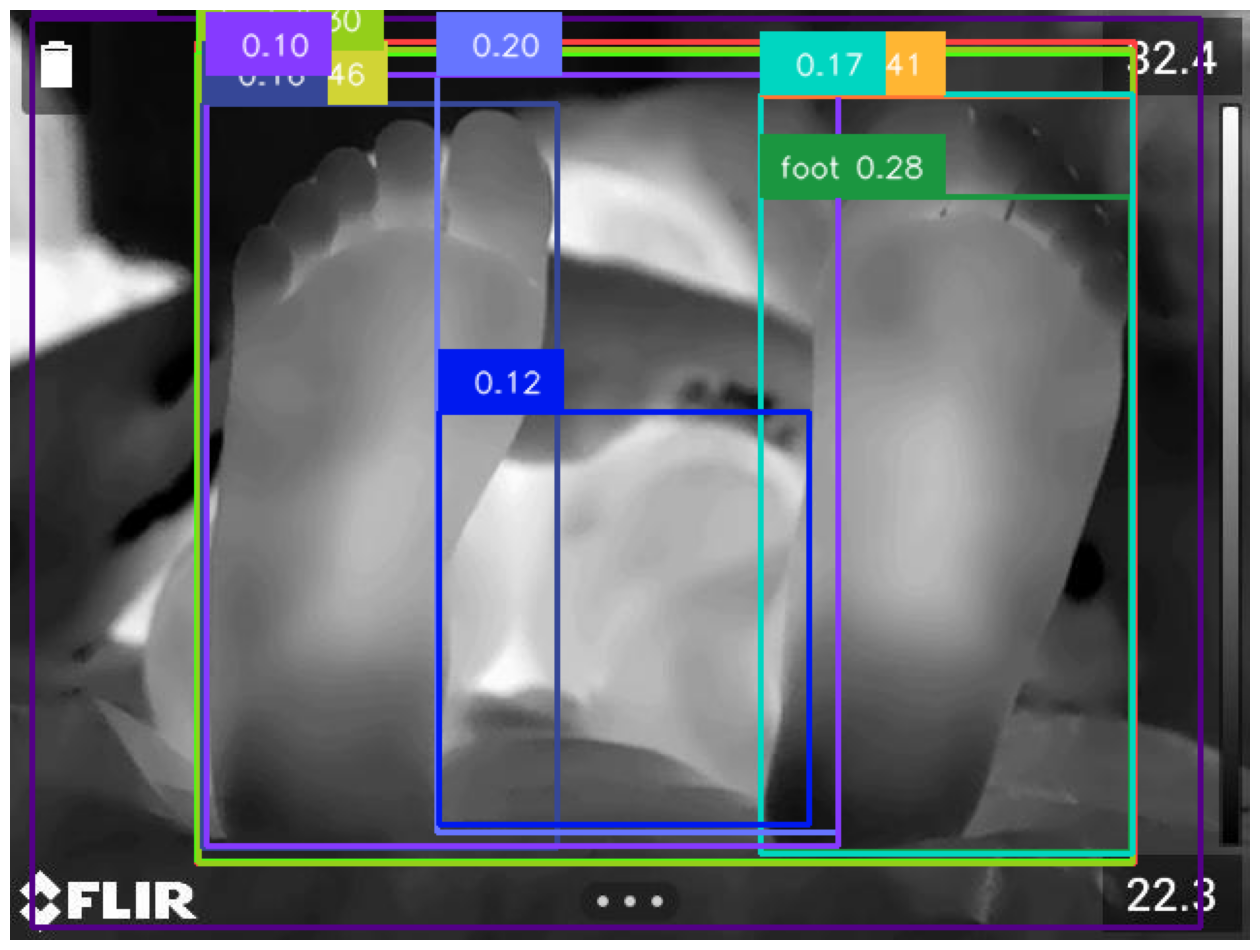

In [18]:
plot_image(np.asarray(imgp),boxes,logits,phrases)

In [19]:

boxes,logits,phrases,images,ids,masks_o,masks_p = model.LangSam_batch(image_data=val_dataset,
                                                                      text_prompt=text_prompt,
                                                                      box_threshold=box_threshold,
                                                                      process_box_threshold=process_box_threshold,
                                                                      text_threshold=text_threshold,
                                                                      mode_predict='box_predict',
                                                                      mode_data='batch')

In [20]:
masks_p.shape

(38, 480, 640, 1)

In [23]:
from Metrics.Metrics import Metrics
metrics_sum = {
    'jaccard': 0,
    'dice': 0,
    'sensitivity': 0,
    'specificity': 0
}
for i in range(masks_o.shape[0]):
    y_true = torch.Tensor(masks_o[i, :, :, :])
    y_pred = torch.Tensor(masks_p[i, :, :, :])

    metrics = Metrics().calculate_metrics(y_pred=y_pred,y_true=y_true)
    print(Metrics().calculate_confusion_matrix(y_pred=y_pred,y_true=y_true))
    print(metrics)
    metrics_sum['jaccard'] += metrics['jaccard']
    metrics_sum['dice'] += metrics['dice']
    metrics_sum['sensitivity'] += metrics['sensitivity']
    metrics_sum['specificity'] += metrics['specificity']

metrics_avg = {metric: metrics_sum[metric] / masks_o.shape[0] for metric in metrics_sum}

(tensor(0.), tensor(11.), tensor(64747.), tensor(242442.))
{'jaccard': 0.0, 'dice': 0.0, 'sensitivity': 0.0, 'specificity': 0.9999546408653259}
(tensor(0.), tensor(15.), tensor(97075.), tensor(210110.))
{'jaccard': 0.0, 'dice': 0.0, 'sensitivity': 0.0, 'specificity': 0.9999285936355591}
(tensor(0.), tensor(37.), tensor(76882.), tensor(230281.))
{'jaccard': 0.0, 'dice': 0.0, 'sensitivity': 0.0, 'specificity': 0.9998393654823303}
(tensor(0.), tensor(22.), tensor(77652.), tensor(229526.))
{'jaccard': 0.0, 'dice': 0.0, 'sensitivity': 0.0, 'specificity': 0.9999041557312012}
(tensor(0.), tensor(37.), tensor(53237.), tensor(253926.))
{'jaccard': 0.0, 'dice': 0.0, 'sensitivity': 0.0, 'specificity': 0.999854326248169}
(tensor(0.), tensor(43.), tensor(76544.), tensor(230613.))
{'jaccard': 0.0, 'dice': 0.0, 'sensitivity': 0.0, 'specificity': 0.9998135566711426}
(tensor(0.), tensor(33.), tensor(57374.), tensor(249793.))
{'jaccard': 0.0, 'dice': 0.0, 'sensitivity': 0.0, 'specificity': 0.99986791610

In [27]:
import matplotlib.pyplot as plt

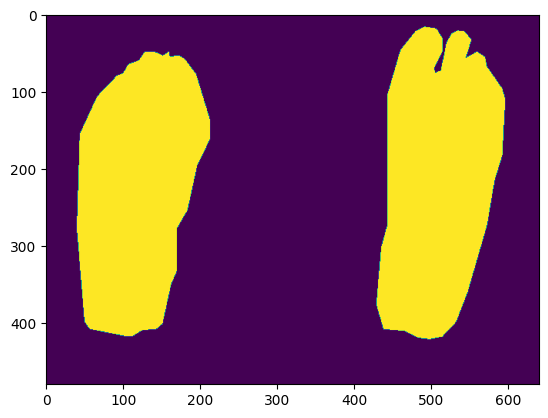

In [31]:
plt.imshow(masks_o[1])

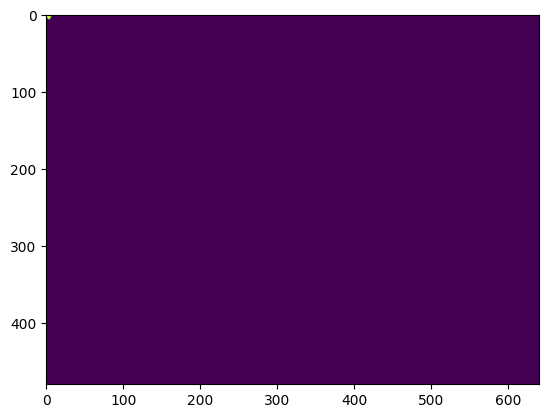

In [34]:
plt.imshow(masks_p[4])

In [41]:
type(images[0])

numpy.ndarray

In [42]:
boxes[0].shape

torch.Size([2, 4])

In [37]:
model.predict_sam_with_boxes(images[0],boxes=[0])

AttributeError: 'list' object has no attribute 'reshape'

In [39]:
images[0].shape

(480, 640, 3)